In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/DF5_Analysis.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/Label_Analysis.pkl") 

# data unknown
df_unknown = pd.read_pickle("../Data/Unknown_Analysis.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/Remove_Analysis.pkl")

# new columns
df_new = pd.read_pickle("../Data/New_Analysis.pkl")

# can columns
df_can = pd.read_pickle("../Data/CAN_Analysis.pkl")

# don columns
df_don = pd.read_pickle("../Data/DON_Analysis.pkl")

# both columns
df_both = pd.read_pickle("../Data/Both_Analysis.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Remove Column(s) Data rows: {len(df_remove)}")
print(f"Donor Column(s) Data rows: {len(df_don)}")
print(f"Candidate Column(s) Data rows: {len(df_can)}")
print(f"Both Column(s) Data rows: {len(df_both)}")

Orginal Data file Shape: (15282, 286)
Label(s) Data rows: 11
Remove Column(s) Data rows: 92
Donor Column(s) Data rows: 87
Candidate Column(s) Data rows: 171
Both Column(s) Data rows: 22


### User Function(s):

In [4]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
        

def find_duplicates(lst):
    return list(set([item for item in lst if lst.count(item) > 1]))
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth):
    """
    Run helper fuction for house keeping
    """
    # update data dictionary (house keeping)
    dataDict = updateDataDict(dataDict, removeCol)
    
    # remove DataFrame data (house keeping)
    dataRemove = removeRowUsingMask(dataRemove, removeColLst, colstr='remove')
    dataUnknown = removeRowUsingMask(dataUnknown, removeColLst, colstr='unknown')
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataNew = removeRowUsingMask(dataNew, removeColLst, colstr='new')
    dataCAN = removeRowUsingMask(dataCAN, removeColLst, colstr='can')
    dataDON = removeRowUsingMask(dataDON, removeColLst, colstr='don')
    dataBoth = removeRowUsingMask(dataBoth, removeColLst, colstr='both')
    
    # remove features
    data = removeColumn(data, removeCol)

    return data, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")

### Remove NaNs

In [5]:
# remove NaNs
df = df.dropna()

# display shape
print(df.shape)

(8557, 286)


### Copy Dataset

In [6]:
# copy dataset
df_copy = df.copy()

### Examine Labels

In [7]:
df_label

,label
0,AcuteRejectionEpisode_CAN
1,StrokePostTransplant_CAN
2,PacemakerPostTransplant_CAN
3,GraftFailed_CAN
4,LastFollowupNumber_CAN
5,TransplantStatus_CAN
6,TransplantSurvivalDay_CAN
7,RecipientStatus_CAN
8,RejectionTreatmentWithinOneYear_CAN
9,GraftStatus_CAN


### TransplantStatus_CAN Classification 

In [8]:
df_dict[df_dict.featureName.str.contains('TransplantStatus_CAN')]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
213,TransplantStatus_CAN,"Boolean Most Recent Patient Status (based on composite death date) (1=Dead, 0=Alive)",TRR/TRF-CALCULATED,PATIENT STATUS,Nominal - NUM,Boolean Most Recent Patient Status (based on composite death date),Unknown,Label - {'PSTATUS': 'TransplantStatus_CAN'}


 #### Remove unwanted Label(s)

In [9]:
# initialize label columns list
removeCol = df_label.label.to_list()

# remove label TransplantStatus_CAN
removeCol.remove('TransplantStatus_CAN')

# house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'GraftFailed_CAN', 'LastFollowupNumber_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 8,557 & columns: 286
Total rows after: 8,557 & columns: 276


In [9]:
# multi class classfication
print(df.TransplantStatus_CAN.unique())

# value counts
print(df.TransplantStatus_CAN.value_counts())

[0, 1, 999]
Categories (3, Int64): [0, 1, 999]
TransplantStatus_CAN
0      13005
1       1852
999      425
Name: count, dtype: int64


Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'GraftFailed_CAN', 'LastFollowupNumber_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 15,282 & columns: 286
Total rows after: 15,282 & columns: 276


In [11]:
# remove unwanted
removeCol = df_remove.remove.to_list()

# house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['Gender_CAN', 'Gender_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'Citizenship_CAN', 'Citizenship_DON', 'HomeState_DON', 'ResidencyState_CAN', 'ResidencyStateAfter_CAN', 'LifeSupport_ECMO_CAN', 'LifeSupportAfter_ECMO_CAN', 'LifeSupport_IABP_CAN', 'LifeSupportAfter_IABP_CAN', 'IntropesIV_CAN', 'IntropesIVAfter_CAN', 'LifeSupport_PGE_CAN', 'LifeSupportAfter_PGE_CAN', 'LifeSupport_OTHER_CAN', 'LifeSupportAfter_OTHER_CAN', 'VentricularDeviceType_CAN', 'VentricularDeviceTypeAfter_CAN', 'VentricularDeviceBrand_CAN', 'VentricularDeviceBrandAfter_CAN', 'FunctionalStatus_CAN', 'FollowUpFunctionalStatus_CAN', 'FunctionalStatusAfter_CAN', 'PrimaryPaymentSource_CAN', 'PrimaryPaymentSourceAfte

### Determine DataFrame Datatypes 

In [13]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  184

Boolean feature count: 38
Category feature count: 98
Numeric feature count: 47
Object feature count: 1

Total feature count:  184


In [14]:
# display objCol
df[objCol].head()

,CombinedMeds
2,"ALBUTEROL, AZITHROMYCIN, LEVAQUIN, MEROPENEM, MICAFUNGIN, MUCOMYST, VANCOMYCIN, VECURONIUM"
4,"ALBUTEROL, ANCEF"
5,"DOPAMINE, LEVOPHED, NYSTATIN/BETADINE"
6,"ANCEF, LEVAQUIN, NEOSYNEPHRINE, ROCURONIUM, ZOSYN"
8,"ANCEF, FENTANYL, VECURONIUM"


In [15]:
# remove CombinedMeds column
df = removeColumn(df, objCol)


Removed Features:['CombinedMeds']

Total rows before: 8,557 & columns: 184
Total rows after: 8,557 & columns: 183


In [16]:
# remove unknow (999) target
df = df[df.TransplantStatus_CAN != 999]

# remove the '999' category
df['TransplantStatus_CAN'] = df['TransplantStatus_CAN'].cat.remove_categories([999])

# shpae
df.shape

(8557, 183)

### Encoding

In [17]:
# import libraries
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

In [18]:
# # ordinal list
# ordinalCol = ['DiabetesHistory_DON', 'EducationLevel_CAN', 'InitialFunctionalStatus_DON', 'FunctionalStatus_CAN', 'FunctionalStatus_DON', 'PreTransplantMedicalCondition_CAN']
# # nominal list
# nominalCol =  pd.Series(catCol)[~pd.Series(catCol).isin(ordinalCol)].to_list()

# # ordinal list
# ordering = ['Unknown', '100% - Normal, no complaints, no evidence of disease', '90% - Able to carry on normal activity: minor symptoms of disease', 
#             '80% - Normal activity with effort: some symptoms of disease', '70% - Cares for self: unable to carry on normal activity or active work',
#             '60% - Requires occasional assistance but is able to care for needs', '50% - Requires considerable assistance and frequent medical care',
#             '40% - Disabled: requires special care and assistance', '30% - Severely disabled: hospitalization is indicated, death not imminent',
#             '20% - Very sick, hospitalization necessary: active treatment necessary', '10% - Moribund, fatal processes progressing rapidly'
#            ]


# # apply OrdinalEncoder - FunctionalStatus_CAN
# encoder = OrdinalEncoder(categories=[ordering])
# df['FunctionalStatus_CAN'] = encoder.fit_transform(df[['FunctionalStatus_CAN']])

# # apply OrdinalEncoder - FunctionalStatus_DON
# encoder = OrdinalEncoder(categories=[ordering])
# df['FunctionalStatus_DON'] = encoder.fit_transform(df[['FunctionalStatus_DON']])

# # apply OrdinalEncoder - InitialFunctionalStatus_DON
# encoder = OrdinalEncoder(categories=[ordering])
# df['InitialFunctionalStatus_DON'] = encoder.fit_transform(df[['InitialFunctionalStatus_DON']])

# ordinal list
ordinalCol = ['DiabetesHistory_DON', 'EducationLevel_CAN', 'PreTransplantMedicalCondition_CAN']
# nominal list
nominalCol =  pd.Series(catCol)[~pd.Series(catCol).isin(ordinalCol)].to_list()

# ordinal list
ordering = ['Unknown', 'Not Hospitalized', 'Hospitalized Not in ICU', 'In Intensive Care Unit']

# apply OrdinalEncoder - PreTransplantMedicalCondition_CAN
encoder = OrdinalEncoder(categories=[ordering])
df['PreTransplantMedicalCondition_CAN'] = encoder.fit_transform(df[['PreTransplantMedicalCondition_CAN']])


# DiabetesHistory_DON
ordering = ['Unknown','No','Yes, Duration Unknown','Yes, 0-5 years','Yes, >10 years','Yes, 6-10 years']

# apply OrdinalEncoder - DiabetesHistory_DON
encoder = OrdinalEncoder(categories=[ordering])
df['DiabetesHistory_DON'] = encoder.fit_transform(df[['DiabetesHistory_DON']])


# EducationLevel_CAN
ordering = ['UNKNOWN','NONE','GRADE SCHOOL (0-8)','HIGH SCHOOL (9-12) or GED','ATTENDED COLLEGE/TECHNICAL SCHOOL','ASSOCIATE/BACHELOR DEGREE','POST-COLLEGE GRADUATE DEGREE']

# apply OrdinalEncoder - EducationLevel_CAN
encoder = OrdinalEncoder(categories=[ordering])
df['EducationLevel_CAN'] = encoder.fit_transform(df[['EducationLevel_CAN']])

df[ordinalCol].head(10)

,DiabetesHistory_DON,EducationLevel_CAN,PreTransplantMedicalCondition_CAN
0,1.0,3.0,1.0
1,1.0,5.0,1.0
2,1.0,3.0,2.0
3,1.0,5.0,1.0
4,3.0,6.0,1.0
5,1.0,3.0,1.0
6,1.0,6.0,1.0
7,1.0,5.0,2.0
8,1.0,4.0,1.0
9,1.0,3.0,3.0


In [19]:
# find all binary categories exclude boolean
catBinary = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype != 'bool']

# display
print(catBinary)

['PreviousMalignancy_CAN', 'Hispanic_CAN', 'TransplantStatus_CAN', 'DeceasedRetyped_DON', 'CrossMatch', 'PreviousTransplantSameOrgan_CAN', 'PreviousTransplantAnyOrgan_CAN', 'Antibody_HEP_C_DON', 'NonHeartBeating_DON', 'BloodInfectionSource_DON', 'Thyroxine_T4_DON', 'PulmonaryInfection_DON', 'UrineInfection_DON', 'ResultHCV_NAT_DON', 'ResultHIV_NAT_DON', 'TransplantType_CAN', 'KidneyAllocation_DON', 'PulmCath_DON']


In [20]:
df[catBinary].describe().T

,count,unique,top,freq
PreviousMalignancy_CAN,8557,2,N,7753
Hispanic_CAN,8557,2,0,7793
TransplantStatus_CAN,8557,2,0,7502
DeceasedRetyped_DON,8557,2,Y,6082
CrossMatch,8557,2,Y,8296
PreviousTransplantSameOrgan_CAN,8557,2,N,8307
PreviousTransplantAnyOrgan_CAN,8557,2,N,8288
Antibody_HEP_C_DON,8557,2,Negative,7755
NonHeartBeating_DON,8557,2,N,8368
BloodInfectionSource_DON,8557,2,0,7673


In [21]:
# change data type to boolean except TransplantType_CAN & TransplantStatus_CAN
catBinary.remove('TransplantType_CAN')
catBinary.remove('TransplantStatus_CAN')

# mapping the values
mapping = {
    1: True,
    0: False,
    'Y': True,
    'N': False,
    'Negative': False,
    'Positive': True
}

# apply the mapping to each relevant column using map
for col in catBinary:
    df[col] = df[col].map(mapping)

# change datatype
df[catBinary] = df[catBinary].astype('bool')

# display head
df[catBinary].head()

,PreviousMalignancy_CAN,Hispanic_CAN,DeceasedRetyped_DON,CrossMatch,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,Antibody_HEP_C_DON,NonHeartBeating_DON,BloodInfectionSource_DON,Thyroxine_T4_DON,PulmonaryInfection_DON,UrineInfection_DON,ResultHCV_NAT_DON,ResultHIV_NAT_DON,KidneyAllocation_DON,PulmCath_DON
0,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,True,True,True,False,False,False,False
2,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False
3,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False
4,False,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False


In [22]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  183

Boolean feature count: 54
Category feature count: 79
Numeric feature count: 50
Object feature count: 0

Total feature count:  183


In [23]:
print(sorted(catCol))

['AirwayDehiscencePostTransplant_CAN', 'AllocationType', 'AntibodyResultHBSAB_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'BloodGroupMatchLevel', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'CMVStatusAtTransplant_CAN', 'CancerSite_DON', 'CardiacArrest_DON', 'CauseOfDeath_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteAbstinence_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'DeathCircumstance_DON', 'DeathMechanism_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'Diabetes_DON', 'DiagnosisType_CAN', 'DialysisType_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_IGG_DON', 'EpsteinBarr_IGM_DON', 'ExtracanialCancer_DON', 'HeartProcedureType_CAN', 'HeavyAlcoholUse_DON', 'HeparinManagement_DON', 'Hepatitis_B_CoreAntibody_CAN', 'Hepatitis_B_CoreAntibody_DON', 'HistoryCancer_DON', 'Hypertension_DON', 'InfectionTherapyIV_CAN', 'Ino

In [24]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
df = pd.get_dummies(df, columns=catCol, drop_first=True)
df.head()

,PreviousTransplantNumber_CAN,EducationLevel_CAN,PreviousMalignancy_CAN,TotalDayWaitList_CAN,Hispanic_CAN,PreTransplantMedicalCondition_CAN,TransplantStatus_CAN,DeceasedRetyped_DON,CrossMatch,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,AntigenHistocompatibility_A1_DON,AntigenHistocompatibility_A2_DON,AntigenHistocompatibility_B1_DON,AntigenHistocompatibility_B2_DON,AntigenHistocompatibility_DR1_DON,AntigenHistocompatibility_DR2_DON,AntigenHLAcompatibility_A1_CAN,AntigenHLAcompatibility_A2_CAN,AntigenHLAcompatibility_B1_CAN,AntigenHLAcompatibility_B2_CAN,AntigenHLAcompatibility_DR1_CAN,AntigenHLAcompatibility_DR2_CAN,Antibody_HEP_C_DON,NonHeartBeating_DON,BloodInfectionSource_DON,BloodUreaNitrogenLevel_DON,OtherInfectionSource_DON,Thyroxine_T4_DON,PulmonaryInfection_DON,Level_SGOT_AST_DON,Level_SGOT_ALT_DON,UrineInfection_DON,DiabetesHistory_DON,ResultHCV_NAT_DON,ResultHIV_NAT_DON,IschemicTimeHours_DON,DistanceFrom_DON_HospitaltoTXCenter,LungPO2_DON,LV_EjectionFractionPercent_DON,KidneyAllocation_DON,LungPO2_FIO2_DON,PCO2_DON,PulmCath_DON,BloodPH_DON,Hematocrit_DON,Gender_difference,BloodGroup_difference,WeightKg_difference,WeightKg_DON,WeightKg_CAN,HeightCm_difference,HeightCm_DON,HeightCm_CAN,BMI_difference,BMI_DON,BMI_CAN,Citizenship_difference,ResidencyState_difference,ResidencyState_CAN_difference,LifeSupport_ECMO_CAN_difference,LifeSupport_IABP_CAN_difference,IntropesIV_CAN_difference,LifeSupport_PGE_CAN_difference,LifeSupport_OTHER_CAN_difference,VentricularDeviceType_CAN_difference,VentricularDeviceBrand_CAN_difference,FunctionalStatus_CAN_difference,FunctionalStatus_FollowUp_CAN_difference,PrimaryPayment_CAN_difference,Dialysis_CAN_difference,DialysisDischarge_CAN_difference,CreatinineAfter_CAN_difference,Creatinine_difference,HemodynamicsAfter_CO_CAN_difference,HemodynamicsAfter_PA_DIA_CAN_difference,HemodynamicsAfter_PA_MN_CAN_difference,HemodynamicsAfter_PCW_CAN_difference,HemodynamicsAfter_SYS_CAN_difference,IntropesVasodilatorsAfter_CO_CAN_difference,IntropesVasodilatorsAfter_DIA_CAN_difference,IntropesVasodilatorsAfter_MN_CAN_difference,IntropesVasodilatorsAfter_PCW_CAN_difference,IntropesVasodilatorsAfter_SYS_CAN_difference,Cigarette_difference,PriorCardiacSurgery_CAN_difference,PriorCardiacSurgeryType_CAN_difference,Age_difference,LifeSupport_CAN_difference,Status_CAN_difference,Status_difference,Ethnicity_difference,Ventilator_CAN_difference,WorkForIncome_CAN_difference,AntigenBW_CAN_difference,AntigenC_CAN_difference,AntigenDR5_12_CAN_difference,AntigenDR5_22_CAN_difference,AntigenDR5_32_CAN_difference,AntigenDQ_CAN_difference,TotalBilirubin_difference,LifeSupportInhaled_CAN_difference,CalcPanelReactiveAntibody_CPRA_CAN_difference,RecoveryTransplant_difference,AdmissionDischarge_CAN_difference,WaitListDiagnosisCode_CAN_CANCER,WaitListDiagnosisCode_CAN_CONGENITAL HEART DEFECT - PRIOR SURGERY UNKNOWN,WaitListDiagnosisCode_CAN_CONGENITAL HEART DEFECT - WITH SURGERY,WaitListDiagnosisCode_CAN_CONGENITAL HEART DEFECT - WITHOUT SURGERY,WaitListDiagnosisCode_CAN_CORONARY ARTERY DISEASE,WaitListDiagnosisCode_CAN_COVID-19: DILATED MYOPATHY: ACTIVE MYOCARDITIS,WaitListDiagnosisCode_CAN_COVID-19: DILATED MYOPATHY: HISTORY OF MYOCARDITIS,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: ADRIAMYCIN,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: ALCOHOLIC,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: FAMILIAL,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: IDIOPATHIC,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: ISCHEMIC,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: MYOCARDITIS,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: OTHER SPECIFY,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: POST PARTUM,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: VIRAL,WaitListDiagnosisCode_CAN_DILATED MYOPATHY: VIRAL (NOT COVID-19),WaitListDiagnosisCode_CAN_HEART RE-TX/GF: ACUTE REJECTION,WaitListDiagnosisCode_CAN_HEART RE-TX/GF: CHRONIC REJECTION,WaitListDiagnosisCode_CAN_HEART RE-TX/GF: CORONARY ARTERY DISEASE,WaitListDiagnosisCode_CAN_HEART RE-TX/GF:

In [25]:
df.shape

(8557, 460)

In [26]:
# split test and train
from sklearn.model_selection import train_test_split

# df DataFrame and
X = df.drop('TransplantStatus_CAN', axis=1)
y = df['TransplantStatus_CAN']

# split the dataset into 80% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# split train data into validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [27]:
y_train.value_counts()

TransplantStatus_CAN
0    4201
1     590
Name: count, dtype: int64

In [28]:
y_val.value_counts()

TransplantStatus_CAN
0    1050
1     148
Name: count, dtype: int64

In [29]:
y_test.value_counts()

TransplantStatus_CAN
0    2251
1     317
Name: count, dtype: int64

In [30]:
X_train[ordinalCol].head()

,DiabetesHistory_DON,EducationLevel_CAN,PreTransplantMedicalCondition_CAN
3882,1.0,3.0,1.0
347,1.0,4.0,1.0
3312,1.0,5.0,1.0
4189,1.0,6.0,1.0
1300,1.0,5.0,1.0


In [31]:
# MinMax Scaling
scaler = MinMaxScaler()

# fit
MinMaxScale = scaler.fit(X_train)

# transform
X_train_scaled = MinMaxScale.transform(X_train)
X_val_scaled = MinMaxScale.transform(X_val)
X_test_scaled = MinMaxScale.transform(X_test)

# convert the scaled data back into a DataFrame with the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# change datatype for FAMD
X_train_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_val_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_test_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')

In [32]:
X_train_scaled_df.shape

(4791, 459)

### Factor Analysis of Mixed Data (FAMD)

In [33]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_3 = prince.FAMD(n_components=459, n_iter=3, random_state=RANDOM_STATE).fit(X_train_scaled_df)
famd_5 = prince.FAMD(n_components=459, n_iter=5, random_state=RANDOM_STATE).fit(X_train_scaled_df)

# checking loading stability - get column contributions
famd_3_contributions = famd_3.column_contributions_
famd_5_contributions = famd_5.column_contributions_

# compare contributions between 3 iterations and 5 iterations
contribution_diff = famd_5_contributions - famd_3_contributions

In [35]:
# display
contribution_diff.head()

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PreviousTransplantNumber_CAN,2.581756e-18,-1.952834e-18,-3.122502e-17,6.938894e-17,-4.542807e-17,4.540097e-19,-1.219727e-18,-2.768104e-18,4.429982e-18,-4.175872e-19,1.025249e-17,-6.803369e-18,-4.506215e-18,-5.271933e-18,3.659182e-19,-3.677478e-17,3.245830e-17,1.335602e-17,-1.803545e-18,8.809143e-19,1.756535e-18,-2.144687e-18,-7.115077e-20,2.403032e-18,-1.574634e-18,3.320369e-19,4.838252e-18,-2.615638e-18,1.567011e-19,-6.059462e-19,1.280714e-18,-1.852885e-19,-7.602121e-19,1.216339e-18,-2.973086e-18,-3.472835e-20,-2.403456e-20,-4.425747e-19,-1.846532e-19,1.395487e-19,5.336308e-19,2.676624e-19,1.268432e-19,-7.826584e-19,3.489776e-19,-4.743385e-20,-4.158932e-19,3.345780e-19,-1.461132e-19,-2.576674e-18,1.692372e-18,4.404571e-20,-1.799098e-18,2.257343e-18,4.472334e-19,5.481891e-20,-3.604972e-18,-6.893128e-19,-9.486769e-20,6.047815e-19,3.821813e-18,-6.681396e-18,2.046432e-18,-1.101143e-17,2.000353e-17,-8.517763e-18,1.499248e-18,7.033762e-18,-5.158431e-19,-1.931235e-18,-8.863353e-18,-1.396757e-18,5.075421e-18,-6.051203e-17,4.274467e-17,-1.459014e-18,-1.182458e-18,3.253454e-18,1.692711e-17,2.057951e-17,9.334303e-19,-3.271580e-17,-1.639221e-18,1.646632e-18,6.755511e-18,1.021442e-18,-6.583140e-18,6.362911e-18,-2.934122e-18,1.741500e-18,1.222269e-18,1.605551e-18,-2.120123e-18,4.377466e-18,2.488244e-17,-5.312591e-18,-2.016616e-17,1.846532e-18,4.736608e-18,-1.526353e-18,-7.521653e-18,-2.934122e-18,-6.988022e-20,-4.133521e-19,-6.518766e-18,3.117081e-18,2.652230e-17,-2.089800e-17,-1.925412e-19,-6.494202e-18,7.914676e-18,-4.854346e-18,-3.421166e-18,7.589415e-19,-4.343585e-18,3.889575e-18,-7.562310e-18,-3.709327e-17,-1.139768e-17,-2.737610e-18,5.862791e-19,-3.690523e-18,2.645453e-17,1.604619e-16,-9.649399e-17,1.157928e-16,-2.721347e-16,7.337338e-17,4.293441e-17,5.105491e-19,4.122679e

**Note:**
- The differences between the contributions are small (close to zero), the model has likely converged.

In [36]:
# transform the data
X_train_famd = famd_5.transform(X_train_scaled_df)

In [37]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_val = prince.FAMD(n_components=459, n_iter=5, random_state=RANDOM_STATE).fit(X_val_scaled_df)
famd_test = prince.FAMD(n_components=459, n_iter=5, random_state=RANDOM_STATE).fit(X_test_scaled_df)

# transform
X_val_famd = famd_val.transform(X_val_scaled_df)
X_test_famd = famd_test.transform(X_test_scaled_df)

In [38]:
X_train_famd.shape, X_val_famd.shape, X_test_famd.shape

((4791, 459), (1198, 459), (2568, 459))

In [39]:
# select value less than 96%
cumVar = famd_5.cumulative_percentage_of_variance_[famd_5.cumulative_percentage_of_variance_ < 96]

# shape
cumVar.shape

(215,)

In [40]:
# select first 248 loadings
X_train_famd = X_train_famd.iloc[:, :215].copy()
X_val_famd = X_val_famd.iloc[:, :215].copy()
X_test_famd = X_test_famd.iloc[:, :215].copy()

# shape
X_train_famd.shape, X_val_famd.shape, X_test_famd.shape

((4791, 215), (1198, 215), (2568, 215))

### PCA

In [41]:
# initialize PCA object (n_components can be set based on variance explained or manually)
pca = PCA(n_components = 141) 

# fit the PCA model and transform the data
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.fit_transform(X_val_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [42]:
np.cumsum(pca.explained_variance_ratio_)

array([0.0412463 , 0.07968318, 0.11640398, 0.15124385, 0.18288169,
       0.21188897, 0.23801882, 0.26007075, 0.28142846, 0.30224497,
       0.32111155, 0.33932279, 0.35716449, 0.3744068 , 0.39092549,
       0.40628125, 0.42094796, 0.43513278, 0.44860877, 0.46109823,
       0.47331418, 0.48510362, 0.4965974 , 0.5074176 , 0.51818232,
       0.52834057, 0.53833705, 0.54789806, 0.5574361 , 0.56658098,
       0.57569207, 0.5845123 , 0.59302545, 0.60142981, 0.60963542,
       0.61759326, 0.62543965, 0.63318466, 0.64069921, 0.64807213,
       0.65530554, 0.6622645 , 0.66915743, 0.67595687, 0.68257566,
       0.68902034, 0.69533379, 0.70149104, 0.7074906 , 0.71329606,
       0.71902676, 0.72462821, 0.73017705, 0.73555721, 0.7408369 ,
       0.74606591, 0.75097476, 0.75581467, 0.76055034, 0.76522495,
       0.76984971, 0.77440477, 0.7788425 , 0.78318315, 0.78738837,
       0.79152822, 0.79558418, 0.79950771, 0.80339884, 0.80718373,
       0.81091706, 0.81461541, 0.81825841, 0.82179946, 0.82529

In [43]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((4791, 141), (1198, 141), (2568, 141))

### User Function(s)

In [123]:
def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=lda_famd.classes_)
    
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    BalAcc = (Sensitivity + Specificity) / 2
    Prec = TP / (TP + FP)
    F1Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)
    AvgPrec = metrics.average_precision_score(y,pred)

    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(y, pred))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, BalAcc, Prec, F1Score, AvgPrec, roc_auc


def stratified_grid(model, parameters, X_train, y_train, nSplit=10, score = 'recall'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plot_feature_importance(model, df):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    df = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(df.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=(10,5))
    # create a bar plot using Seaborn
    ax = sns.barplot(data=df, y=df.index, x = df['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()


def metricsClassfication(model, desc, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Model', 'Description', 'BalancedAccuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity'])
    # write to DataFrame
    data.loc[len(data)] = [model, desc, BalancedAccuracy, RecallSensitivity, F1, AveragePrecision, Precision, Specificity]

    return data


def metricsRegression(model, desc, MAE, MSE, RMSE, MAPE, R2, AdjR2):
    """
    Pass Regression metrics and Model Information
    """
    # 
    # initialize DataFrame
    data = pd.DataFrame(columns=['Model', 'Description', 'MeanAbsoluteError', 'MeanSquareError','RootMeanSquareError', 'MreanAbsolutePercentageError', 'RSquare','AdjustedRSquare'])
    # write to DataFrame
    data.loc[len(data)] = [model, desc, MAE, MSE, RMSE, MAPE, R2, AdjR2]

    return data


def trainFitModel(X, y, type=None):
    """

    """
    pass
    

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (Coefficient of Determination)
- Mean Absolute Percentage Error (MAPE)

In [56]:
from imblearn.over_sampling import SMOTE

# initialize smote
smote = SMOTE(random_state=RANDOM_STATE)

X_resampled_pca, y_resampled_pca = smote.fit_resample(X_train_pca, y_train)
X_resampled_famd, y_resampled_famd = smote.fit_resample(X_train_famd, y_train)

### Machine Learning

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

#### LinearDiscriminantAnalysis
- Parameters: Solver to use:
    - `svd`: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
    - `lsqr`: Least squares solution, can be combined with shrinkage.
    - `eigen`: Eigenvalue decomposition, can be combined with shrinkage.
- Parameters: Shrinkage parameter: (shrinkagestring or float, optional)
    - `None`: no shrinkage (default).
    - `auto`: automatic shrinkage using the Ledoit-Wolf lemma.
    - float between `0` and `1`: fixed shrinkage parameter.

**Note** that shrinkage works only with ‘lsqr’ and ‘eigen’ solvers.

In [66]:
# initialize the LDA model
lda_famd = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# train the model
lda_famd.fit(X_train_famd, y_train)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      4201
           1       0.68      0.21      0.32       590

    accuracy                           0.89      4791
   macro avg       0.79      0.60      0.63      4791
weighted avg       0.87      0.89      0.86      4791



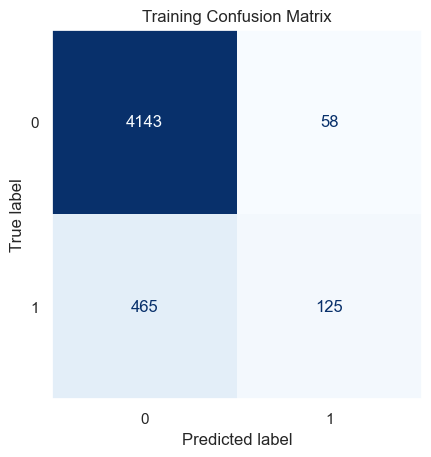

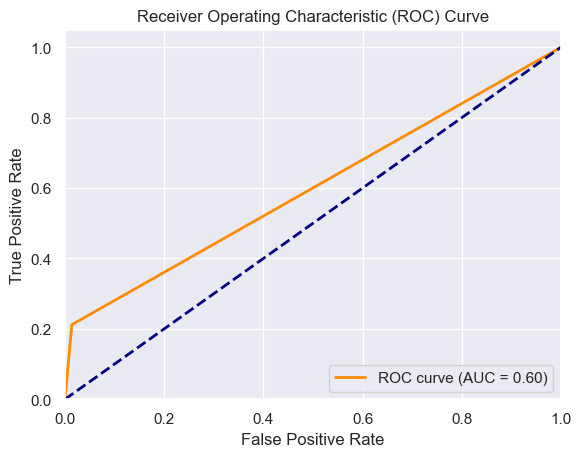

In [97]:
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision AU= classifier_metrics(lda_famd, X_train_famd, y_train, flag = None)

In [52]:
# initialize the LDA model
lda_pca = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# train the model
lda_pca.fit(X_train_pca, y_train)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      4201
           1       0.64      0.18      0.28       590

    accuracy                           0.89      4791
   macro avg       0.77      0.58      0.61      4791
weighted avg       0.86      0.89      0.86      4791



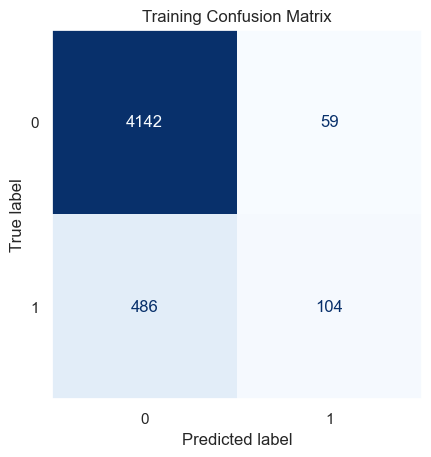

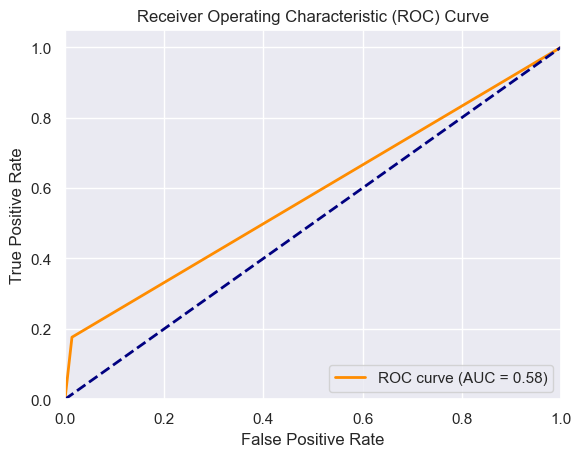

In [53]:
classifier_metrics(lda_pca, X_train_pca, y_train, flag = None)

#### SMOTE

In [54]:
# initialize the LDA model
lda_smote_famd = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# train the model
lda_smote_famd.fit(X_resampled_famd, y_resampled_famd)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74      4201
           1       0.73      0.75      0.74      4201

    accuracy                           0.74      8402
   macro avg       0.74      0.74      0.74      8402
weighted avg       0.74      0.74      0.74      8402



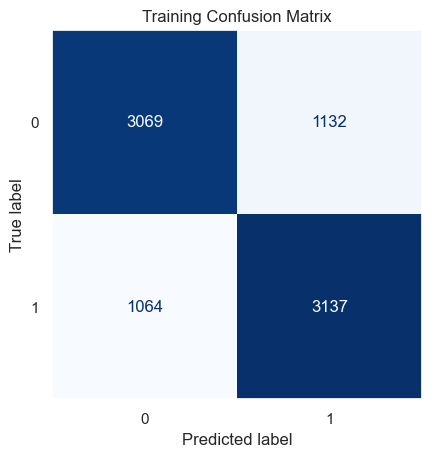

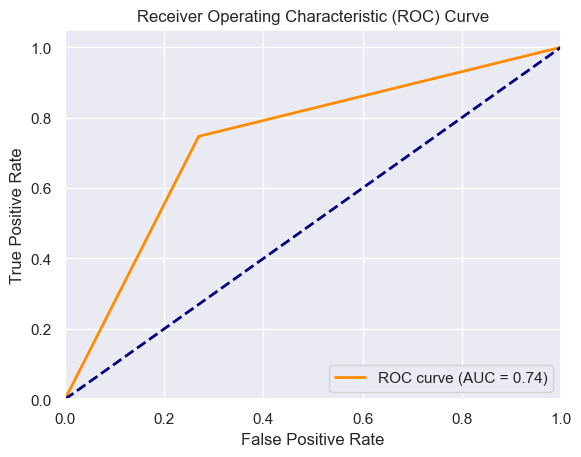

In [55]:
classifier_metrics(lda_smote_famd, X_resampled_famd, y_resampled_famd, flag = None)

In [56]:
# initialize the LDA model
lda_smote_pca = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# train the model
lda_smote_pca.fit(X_resampled_pca, y_resampled_pca)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74      4201
           1       0.74      0.73      0.73      4201

    accuracy                           0.73      8402
   macro avg       0.73      0.73      0.73      8402
weighted avg       0.73      0.73      0.73      8402



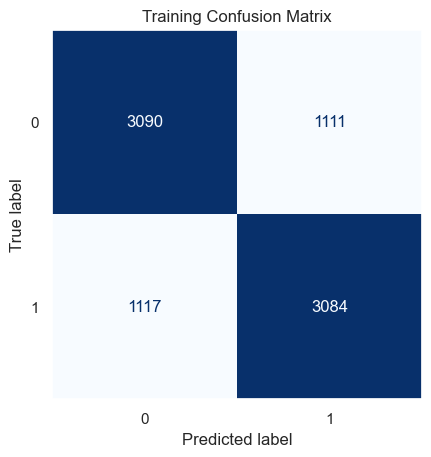

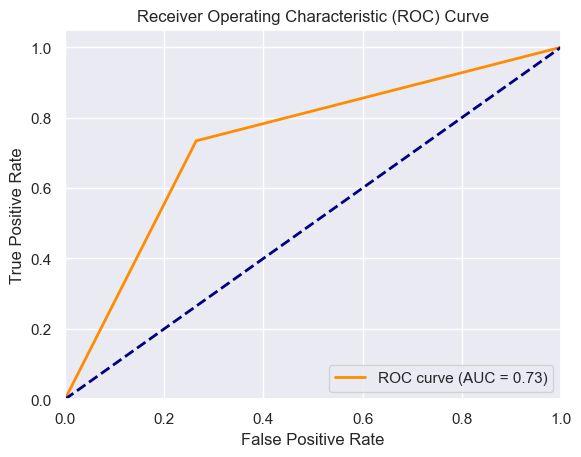

In [57]:
classifier_metrics(lda_smote_pca, X_resampled_pca, y_resampled_pca, flag = None)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76      2251
           1       0.11      0.31      0.17       317

    accuracy                           0.62      2568
   macro avg       0.49      0.49      0.46      2568
weighted avg       0.78      0.62      0.68      2568



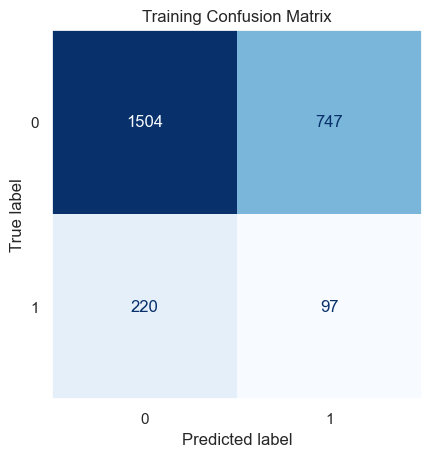

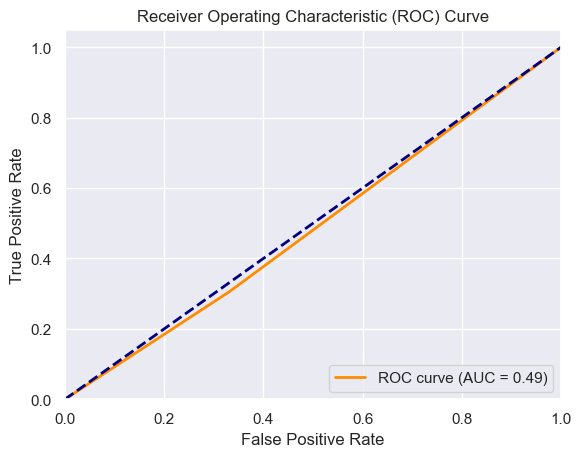

In [58]:
# metrics
classifier_metrics(lda_smote_pca, X_test_pca, y_test, flag = None)

#### Random Forest Classifier

In [69]:
# initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=50, min_samples_split=20, max_features='sqrt', bootstrap=True, max_samples=0.5, class_weight='balanced', random_state=RANDOM_STATE)

# train the model
rf_clf.fit(X_train_famd, y_train)

# predictions
y_pred = rf_clf.predict(X_val_famd)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4201
           1       0.99      0.47      0.64       590

    accuracy                           0.93      4791
   macro avg       0.96      0.74      0.80      4791
weighted avg       0.94      0.93      0.92      4791



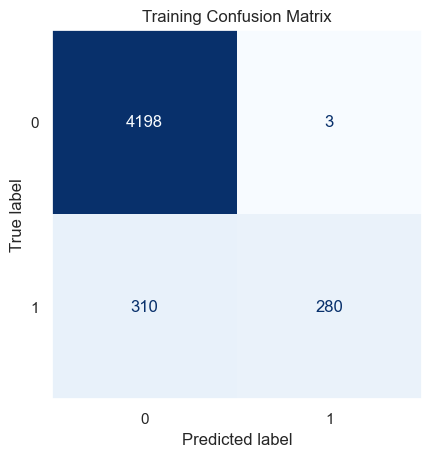

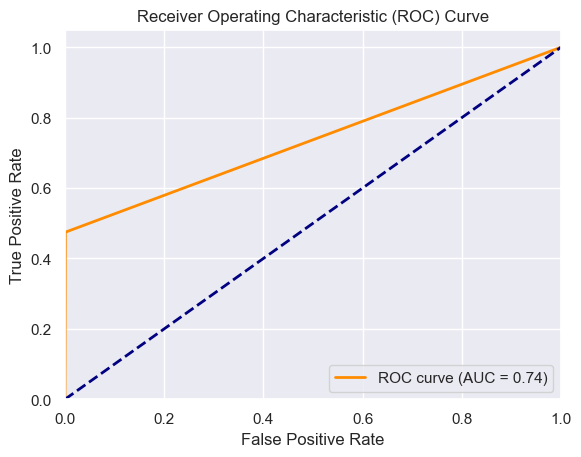

In [70]:
classifier_metrics(rf_clf, X_train_famd, y_train, flag = None)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      1050
           1       0.00      0.00      0.00       148

    accuracy                           0.88      1198
   macro avg       0.44      0.50      0.47      1198
weighted avg       0.77      0.88      0.82      1198



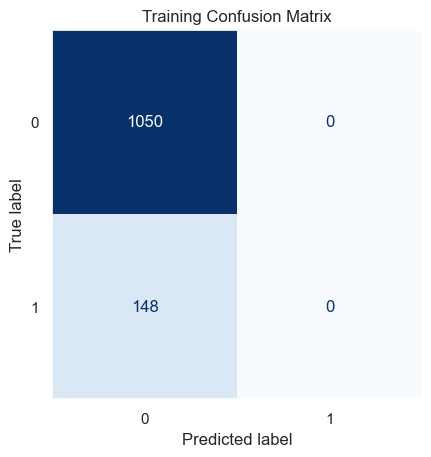

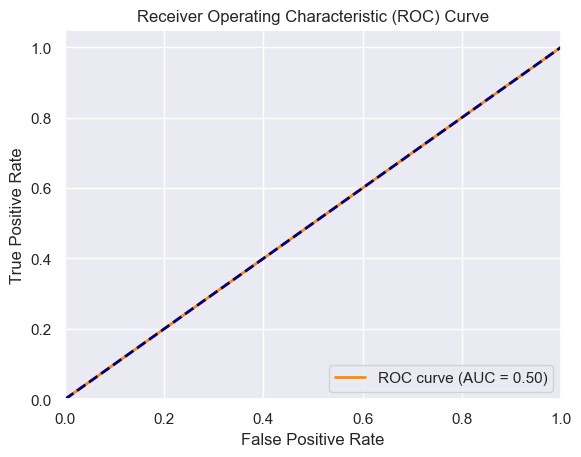

In [71]:
classifier_metrics(rf_clf, X_val_famd, y_val, flag = None)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4201
           1       1.00      0.45      0.62       590

    accuracy                           0.93      4791
   macro avg       0.96      0.73      0.79      4791
weighted avg       0.94      0.93      0.92      4791



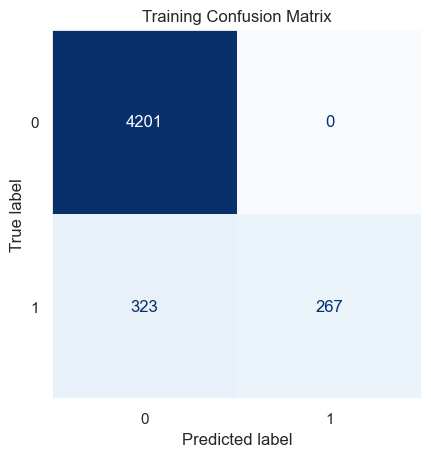

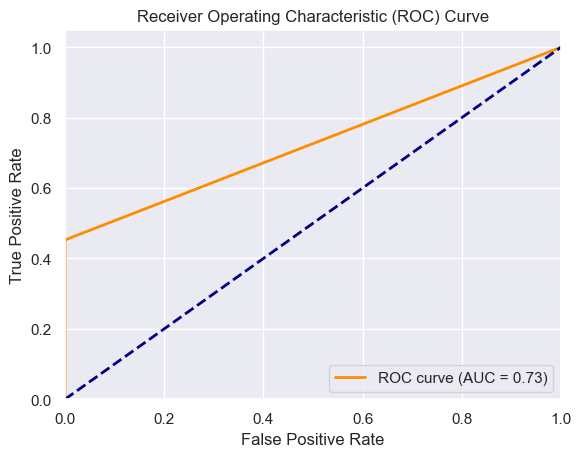

In [72]:
# train the model
rf_clf.fit(X_train_pca, y_train)

# metrics
classifier_metrics(rf_clf, X_train_pca, y_train, flag = None)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      1050
           1       0.00      0.00      0.00       148

    accuracy                           0.88      1198
   macro avg       0.44      0.50      0.47      1198
weighted avg       0.77      0.88      0.82      1198



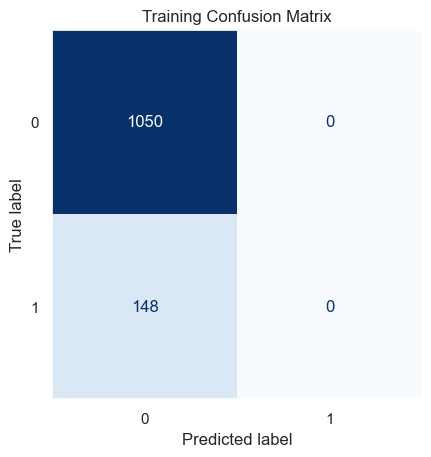

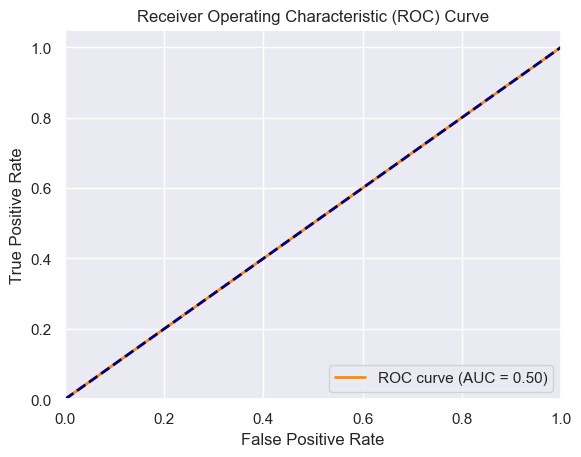

In [73]:
# metrics
classifier_metrics(rf_clf, X_val_pca, y_val, flag = None)

### Save Sample Dataset

In [58]:
# full dataframe
df.to_pickle("../Data/Cleaned_Data.pkl")

# data dictionary
df_dict.to_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label.to_pickle("../Data/Clean_Label.pkl") 

# data unknown
df_unknown.to_pickle("../Data/Clean_Unknown.pkl")

# remove columns
df_remove.to_pickle("../Data/Clean_Remove.pkl")

# new columns
df_new.to_pickle("../Data/Clean_New.pkl")

# new columns
df_can.to_pickle("../Data/Clean_CAN.pkl")

# new columns
df_don.to_pickle("../Data/Clean_DON.pkl")

# new columns
df_both.to_pickle("../Data/Clean_Both.pkl")